In [3]:
# Author: C. Hull (github: chat.hull)

# This is a project analyzing historical data of the air quality in Santiago, Chile

# The data for a representative weather station in central Santiago can be found here:
# https://sinca.mma.gob.cl/index.php/estacion/index/key/D14

# Shout-outs to the many posts/github pages that helped me out!
# Julia Kho: web scraping, https://towardsdatascience.com/how-to-web-scrape-with-python-in-4-minutes-bc49186a8460
# Aditya Sharma: time-series moving averages, https://www.datacamp.com/community/tutorials/moving-averages-in-pandas
# Manish Pathak: concatenating/merging in pandas, https://www.datacamp.com/community/tutorials/joining-dataframes-pandas
# Laura Fedoruk: time-series manipulation in pandas, https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea

In [55]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import requests
from bs4 import BeautifulSoup
import time
from datetime import date
from matplotlib import pyplot as plt

In [56]:
def isfloat(x) :
    try:
        float(x)
        return True
    except:
        return False

In [57]:
# Scrape SINCA website

# Many pollutants, but different stations don't have continuous time coverage of all of them
# SO2, NO, NO2, CO, O3, NOX, non-methanic hydrocarbons, PM10, PM2.5

# For now, focus on PM10, PM2.5, and weather data at the Parque O'Higgins station in central Santiago
station = 'D14'
# Earliest common date is 031215 (constrained by weather data)
date_from = '031215'
# Current date
date_to = date.today().strftime("%y%m%d")

#PM2.5
pm25 = {
    'name' : 'pm2.5',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM25//PM25.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

#PM10
pm10 = {
    'name' : 'pm10',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM10//PM10.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Relative humidity
rhum = {
    'name' : 'rhum',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/RHUM//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Temperature
temp = {
    'name' : 'temp',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/TEMP//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind speed
wspd = {
    'name' : 'wspd',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WSPD//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind direction
wdir = {
    'name' : 'wdir',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WDIR//horario_000_spec.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

In [58]:
def scrapeData(series_url) :
    time.sleep(1)
    response = requests.get(series_url)
    print(response)
    return response

def formatData(html_response) :
    data = html_response.text.split('\n')
    # Clear header and footer text
    data = [ line for line in data if len(line) and isfloat(line[0]) ]
    # Keep lines with date, time, and validated or preliminary data
    data = [ line.split(',')[0:4] for line in data if \
            isfloat(line.split(',')[2]) or isfloat(line.split(',')[3]) ]
    return data

In [59]:
# Empty dataframe; will merge other columns into it one by one
df_tot = pd.DataFrame(columns=['datetime'])

for series in [pm25, pm10, rhum, temp, wspd, wdir] :
    response = scrapeData(series['url'])
    data = formatData(response)
    
    # Format dates
    df = pd.DataFrame.from_records(data, columns=['date', 'time', 'validated', 'preliminary'])
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%y%m%d %H%M')
    df = df.drop(columns=['date', 'time'])
    
    # Combine validated and preliminary-data columns (after replacing white space with NaNs)
    df = df.replace(r'^\s+$', np.nan, regex=True)
    df[series['name']] = df['validated'].combine_first(df['preliminary'])
    df = df.drop(columns=['validated','preliminary'])
    
    # Convert unicode to floats
    df[series['name']] = pd.to_numeric(df[series['name']])
    
    # Merge latest time-series into full DataFrame, resort index
    df_tot = pd.merge(df_tot, df, on='datetime', how='outer')
    df_tot = df_tot.sort_values('datetime')
    df_tot = df_tot.reset_index(drop=True)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [60]:
print(df_tot.tail(n=15))

                  datetime  pm2.5  pm10     rhum     temp      wspd     wdir
157579 2021-12-30 17:00:00    NaN   NaN  31.8333  28.5333  3.234930  126.875
157580 2021-12-30 18:00:00    NaN   NaN  36.1667  27.0833  2.644940  127.464
157581 2021-12-30 19:00:00    NaN   NaN  43.0833  24.7667  2.251480  126.762
157582 2021-12-30 20:00:00    NaN   NaN  50.5833  22.1750  1.722630  119.837
157583 2021-12-30 21:00:00    NaN   NaN  53.2500  20.7500  1.671000  117.198
157584 2021-12-30 22:00:00    NaN   NaN  55.4167  19.7500  1.148390  107.440
157585 2021-12-30 23:00:00    NaN   NaN  58.2500  18.7167  0.401692  102.310
157586 2021-12-31 00:00:00    NaN   NaN  61.8333  17.6667  0.114960  103.093
157587 2021-12-31 01:00:00    NaN   NaN  64.9167  16.4667  0.016099  176.000
157588 2021-12-31 02:00:00    NaN   NaN  66.7500  16.0500  0.253836  152.265
157589 2021-12-31 03:00:00    NaN   NaN  70.4167  15.3083  0.284463  146.884
157590 2021-12-31 04:00:00    NaN   NaN  72.7500  14.5167  0.165170  154.111

In [61]:
# Set datetime column as the index of the dataframe
df_tot = df_tot.set_index('datetime')

In [74]:
## This may not be necessary given the resample feature
# df_tot['pm2.5run'] = df_tot['pm2.5'].rolling(window=4).mean()
# df_tot['pm10run']  = df_tot['pm10'].rolling(window=4).mean()
# df_tot['rhumrun']  = df_tot['rhum'].rolling(window=4).mean()
# df_tot['temprun']  = df_tot['temp'].rolling(window=4).mean()
# df_tot['wspdrun']  = df_tot['wspd'].rolling(window=4).mean()
# df_tot['wdirrun']  = df_tot['wdir'].rolling(window=4).mean()

No handles with labels found to put in legend.


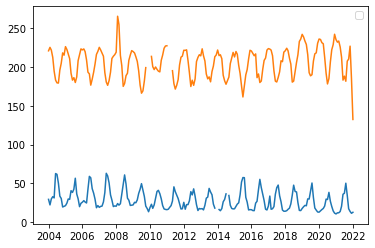

In [109]:
# Sample plots
t_min='2000-01-01'
t_max='2030-01-01'
plt.plot(df_tot['pm2.5'][t_min:t_max].resample('M').mean(),'-')
plt.plot(df_tot['wdir'][t_min:t_max].resample('M').mean(),'-')
plt.legend()

No handles with labels found to put in legend.


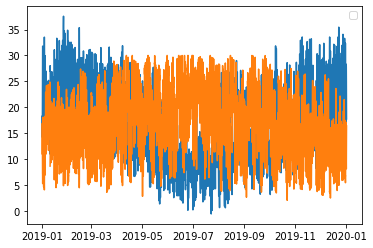

In [96]:
# Sample plots
t_min='2019-01-01'
t_max='2020-01-01'
plt.plot(df_tot['temp'][t_min:t_max],'-')
plt.plot(0.3*df_tot['rhum'][t_min:t_max],'-')
plt.legend()

In [43]:
# TODO: 
# Do PCA on the time series and remove the annual and diurnal signals
# Test correlations: positive (PM2.5 and PM10), and negative (temp and rhum)

In [44]:

# TESTS


In [45]:
df_tot['pm2.5'].resample('M').mean().tail(n=20)

datetime
2020-05-31    29.901617
2020-06-30    29.346424
2020-07-31    38.548518
2020-08-31    27.115591
2020-09-30    20.402507
2020-10-31    14.676075
2020-11-30    11.818056
2020-12-31    10.813725
2021-01-31    12.211022
2021-02-28    12.256716
2021-03-31    13.916019
2021-04-30    20.654596
2021-05-31    36.098383
2021-06-30    37.434783
2021-07-31    50.344086
2021-08-31    34.634278
2021-09-30    17.506944
2021-10-31    13.994429
2021-11-30    11.614206
2021-12-31    12.907154
Freq: M, Name: pm2.5, dtype: float64